## Handwritten Notes to Text
The following notebook tests 4 OCR models:
- Microsoft TrOCR
- Google Document AI Vision OCR v2
- OpenAI GPT-4o
- HuggingFaceM4/idefics2-8b
    > **_NOTE:_**  Do not run on local CPU environments, use with colab gpu runtime or on the chip cluster


#### Load image

Load and display `data/test-note-copy.png` (or replace with your image).

In [1]:
import os
print(os.getcwd())
print(os.listdir())


/Users/poojaguttal/Desktop/notes-to-text/notebooks
['handwritten_ocr.ipynb']


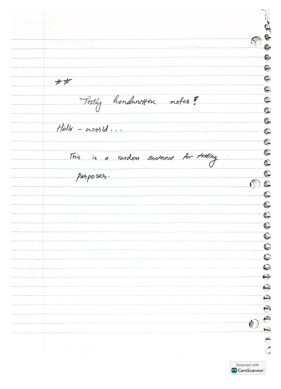

Loaded: ../data/test-note-copy.png


In [2]:
from PIL import Image
import matplotlib.pyplot as plt

IMAGE_PATH = "../data/test-note-copy.png"

img = Image.open(IMAGE_PATH).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.show()

print("Loaded:", IMAGE_PATH)

#### 1. Microsoft TrOCR

In [3]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

def run_trocr(image_path):
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

trocr_text = run_trocr(IMAGE_PATH)
print("TrOCR Result:\n", trocr_text)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TrOCR Result:
 1953 Exchange and the Government of America 1951


#### 2. Google Document AI Vision OCR v2

In [8]:
import os
from dotenv import load_dotenv
from google.cloud import documentai
from PIL import Image

# Load .env variables
load_dotenv()

# Auto-resolve project root (parent of notebooks/)
PROJECT_ROOT = Path().resolve()

GOOGLE_CREDS_REL = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
GOOGLE_CREDS = PROJECT_ROOT / GOOGLE_CREDS_REL

# Google DocAI setup
GCP_PROJECT_ID = os.getenv("GCP_PROJECT_ID")
GCP_LOCATION = os.getenv("GCP_LOCATION", "us")
GCP_PROCESSOR_ID = os.getenv("GCP_PROCESSOR_ID")

processor_name = (
    f"projects/{GCP_PROJECT_ID}/locations/{GCP_LOCATION}/processors/{GCP_PROCESSOR_ID}"
)
client = documentai.DocumentProcessorServiceClient()

# Test connectivity to processor
try:
    client.get_processor(name=processor_name)
except Exception as e:
    raise RuntimeError(f"Error connecting to Document AI:\n{e}")

# OCR function
def run_docai(image_path):
    with open(image_path, "rb") as f:
        file_bytes = f.read()

    mime_type = "application/pdf" if image_path.endswith(".pdf") else "image/png"

    request = {
        "name": processor_name,
        "raw_document": {"content": file_bytes, "mime_type": mime_type},
    }

    result = client.process_document(request=request)
    document = result.document
    return document.text.strip()

image = Image.open(IMAGE_PATH)  # Preview check
docai_text = run_docai(IMAGE_PATH)
print("\n Google DocAI Extracted Text:")
print(docai_text)

NameError: name 'Path' is not defined

#### 3. OpenAI GPT-4o

In [5]:
import base64
import mimetypes
import os
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI(api_key=OPENAI_KEY)


def run_gpt4o(image_path):
    with open(image_path, "rb") as f:
        image_bytes = f.read()

    mime_type = mimetypes.types_map.get(".png", "image/png")
    b64 = base64.b64encode(image_bytes).decode("utf-8")
    data_url = f"data:{mime_type};base64,{b64}"

    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Extract the handwritten text:"},
                    {"type": "image_url", "image_url": {"url": data_url}}
                ]
            }
        ]
    )
    return response.choices[0].message.content.strip()

gpt_text = run_gpt4o(IMAGE_PATH)
print("GPT-4o-mini Result:\n", gpt_text)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

#### 4. HuggingFaceM4/idefics2-8b

> **_NOTE:_**  Do not run on local CPU environments, use with colab gpu runtime or on the chip cluster as the model is large to load on cpu.

In [ ]:
# !pip install transformers accelerate pillow --quiet

# from transformers import AutoModelForVision2Seq, AutoProcessor
# from google.colab import files
# from PIL import Image
# import torch

# # Upload handwritten note image
# print("Upload handwritten note image (png/jpg)")
# uploaded = files.upload()
# file_name = list(uploaded.keys())[0]
# img = Image.open(file_name).convert("RGB")
# display(img)

# # Load model + processor
# model_id = "HuggingFaceM4/idefics2-8b"
# processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
# model = AutoModelForVision2Seq.from_pretrained(
#     model_id,
#     torch_dtype=torch.float16,
#     device_map="auto",
#     trust_remote_code=True,
# )

# # Include <image> token in the prompt
# prompt = "Extract the handwritten text: <image>"

# inputs = processor(
#     text=[prompt],
#     images=[img],
#     return_tensors="pt"
# ).to("cuda")

# generated_ids = model.generate(
#     **inputs,
#     max_new_tokens=300,
# )

# output = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# print("IDEFICS2 OCR Output:")
# print(output.strip())

PP-OCRv5 — Universal Scene Text Recognition
Single model supports five text types (Simplified Chinese, Traditional Chinese, English, Japanese, and Pinyin) with 13% accuracy improvement. Solves multilingual mixed document recognition challenges.

In [2]:
# version used : 4.1 PP-OCRv5
from paddleocr import PaddleOCR

ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False
)

result = ocr.predict(
    input="/Users/poojaguttal/Desktop/notes-to-text/data/test-note-copy.png"
)

output_text_file = "output/ocr_text.txt"

with open("output/ocr_text.txt", "w", encoding="utf-8") as f:
    for res in result:
        for line in res:
            f.write(line + "\n")

print("OCR text saved to output/ocr_text.txt")

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/poojaguttal/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/poojaguttal/.paddlex/official_models/PP-OCRv5_server_rec`.


OCR text saved to output/ocr_text.txt


In [ ]:
# version used : 4.1 PP-OCRv5
from paddleocr import PaddleOCR

ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False
)

result = ocr.predict(
    input="/Users/poojaguttal/Desktop/notes-to-text/data/Sample 1.docx.pdf"
)

output_text_file = "output/ocr_text.txt"

with open("output/ocr_text.txt", "w", encoding="utf-8") as f:
    for res in result:
        for line in res:
            f.write(line + "\n")

print("OCR text saved to output/ocr_text.txt")

In [ ]:
#version used : 4.1 PP-OCRv5
from paddleocr import PaddleOCR
ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False)


result = ocr.predict(
    input="/Users/poojaguttal/Desktop/notes-to-text/data/test-note-copy.png")


for res in result:
    res.print()
    res.save_to_img("output")
    res.save_to_json("output")

Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.
/Users/poojaguttal/Desktop/notes-to-text/ocr/lib/python3.13/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in `/Users/poojaguttal/.paddlex/official_models/PP-OCRv5_server_det`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/903 [00:00<?, ?B/s]

inference.pdiparams:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in `/Users/poojaguttal/.paddlex/official_models/PP-OCRv5_server_rec`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/84.4M [00:00<?, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

{'res': {'input_path': '/Users/poojaguttal/Desktop/notes-to-text/data/test-note-copy.png', 'page_index': None, 'model_settings': {'use_doc_preprocessor': False, 'use_textline_orientation': False}, 'dt_polys': array([[[ 271,  428],
        ...,
        [ 272,  488]],

       ...,

       [[1431, 2270],
        ...,
        [1430, 2297]]], shape=(11, 4, 2), dtype=int16), 'text_det_params': {'limit_side_len': 64, 'limit_type': 'min', 'thresh': 0.3, 'max_side_limit': 4000, 'box_thresh': 0.6, 'unclip_ratio': 1.5}, 'text_type': 'general', 'textline_orientation_angles': array([-1, ..., -1], shape=(11,)), 'text_rec_score_thresh': 0.0, 'return_word_box': False, 'rec_texts': ['☆☆', 'Testiy', 'hondwritten nofes', 'Hells-woild...', 'This is a rendom Sentomnce for testiing', 'purposes.', '', '', 'Scanned with', 'cs', 'CamScanner'], 'rec_scores': array([0.9393214 , ..., 0.99053526], shape=(11,)), 'rec_polys': array([[[ 271,  428],
        ...,
        [ 272,  488]],

       ...,

       [[1431, 2270